<a href="https://colab.research.google.com/github/VikasSharma707/Sunspot_timeseries/blob/main/sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import numpy as np

2.7.0


In [2]:
#create plot
def plot_series(time,series,format='',start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
#Downloading sunspot datasets from kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d robervalt/sunspots

Saving kaggle.json to kaggle.json
  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 8.56MB/s]


In [4]:
!mkdir train
!unzip sunspots.zip -d train

Archive:  sunspots.zip
  inflating: train/Sunspots.csv      


In [5]:
import csv

time_step = []
sunspots = []

with open('/content/train/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

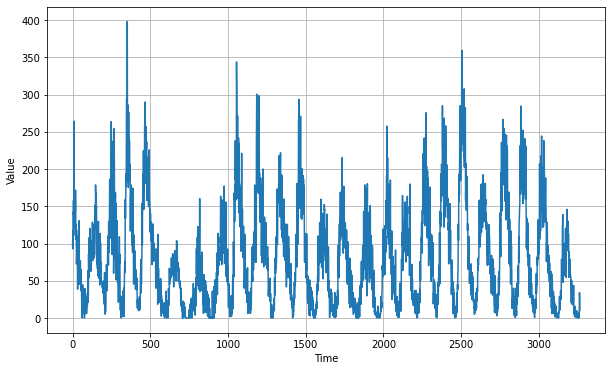

In [6]:
# convert into numpy array to plot the series
time = np.array(time_step)
series = np.array(sunspots)
plt.figure(figsize=(10,6));
plot_series(time,series)


In [7]:
#split time stamp into train and validation data
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [21]:
shuffle_buffer = 1000
window_size = 30
batch_size = 32

In [22]:
#create window
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [30]:
#MOdel 
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 14s 58ms/step - loss: 53.9256 - mae: 54.4235 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 60ms/step - loss: 53.3856 - mae: 53.8836 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 62ms/step - loss: 52.6156 - mae: 53.1139 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 62ms/step - loss: 51.7221 - mae: 52.2204 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 58ms/step - loss: 50.6877 - mae: 51.1862 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 59ms/step - loss: 49.4586 - mae: 49.9570 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 63ms/step - loss: 47.8929 - mae: 48.3910 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 65ms/step - loss: 45.7489 - mae: 46.2470 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 1s 62ms/step - loss: 43.2500 - mae

(1e-08, 0.0001, 0.0, 60.0)

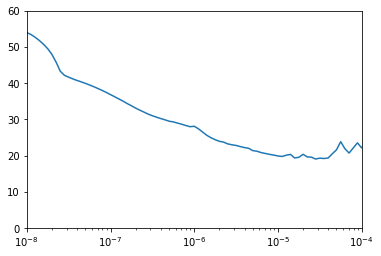

In [31]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 40ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 1s 39ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 1s 38ms/step - loss: 22.0765 - mae: 22.5702
Epoch 4/500
30/30 [==============================] - 1s 39ms/step - loss: 20.4716 - mae: 20.9645
Epoch 5/500
30/30 [==============================] - 1s 39ms/step - loss: 19.7824 - mae: 20.2750
Epoch 6/500
30/30 [==============================] - 1s 38ms/step - loss: 19.2779 - mae: 19.7701
Epoch 7/500
30/30 [==============================] - 1s 38ms/step - loss: 18.7116 - mae: 19.2036
Epoch 8/500
30/30 [==============================] - 1s 38ms/step - loss: 18.1204 - mae: 18.6121
Epoch 9/500
30/30 [==============================] - 1s 38ms/step - loss: 18.0639 - mae: 18.5554
Epoch 10/500
30/30 [==============================] - 1s 38ms/step - loss: 17.9006 - mae: 18.3917
Epoch 11/500
30/30 [=========

In [34]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

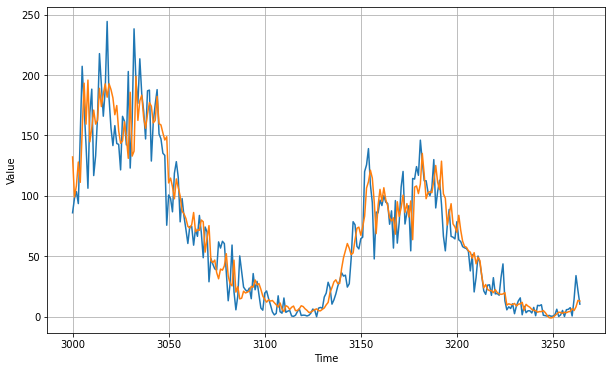

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [36]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

13.502953

<Figure size 432x288 with 0 Axes>

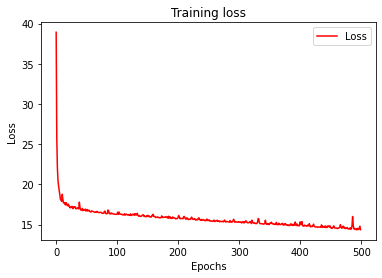

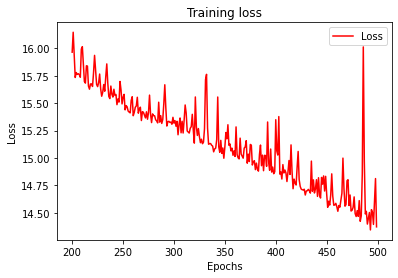

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [38]:
print(rnn_forecast)

[132.18947     99.05363    108.389854   127.99506    111.19304
 153.69699    193.24234    159.35698    195.79814    144.69557
 156.26212    170.95177    159.35208    162.56795    188.97696
 173.87387    184.46521    192.6482     181.62904    192.73593
 187.94887    181.0976     167.13184    174.73988    153.67838
 143.48218    145.49413    161.25583    148.39114    131.0582
 185.70908    132.88197    136.99756    198.88971    162.45296
 178.71446    183.22394    164.80383    155.95634    167.66937
 177.21164    174.1961     160.34477    162.37724    182.3386
 159.74243    158.67946    152.10284    146.22795    148.94243
 110.68784    114.70261    107.56726     97.5567     114.025795
 107.05359     99.85594     87.41173     85.03778     81.25069
  74.74577     73.40092     76.05347     86.21818     70.27283
  71.88999     71.49971     80.025314    78.5951      53.424816
  64.944115    75.361824    46.3698      44.820396    46.879482
  36.46577     31.391987    39.43159     38.510536    